In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
# import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from utils import *

In [19]:
A = sparse.load_npz('../data/33/mat/fd_AD.npz')
D = sparse.diags(A.diagonal())
invD = sparse.diags(1/A.diagonal())
sparse.linalg.norm(D@invD - )


33.0

In [3]:
def jacobi_2nd(A, b, x0, tol=1e-8, max_iterations=1000):
    x = x0
    D = sparse.diags(A.diagonal()).tocsc()
    invD = sparse.linalg.inv(D)
    LU = A - D
    for k in range(max_iterations):     
        x_new = invD@(b - LU@x)
        diff = np.linalg.norm(x_new - x) / np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if diff < tol:    break
        x = x_new
    return x

def gauess_seidel(A, b, tol=1e-8, max_iterations=1000):
    x = np.zeros_like(b, dtype=np.double)
    L = sparse.tril(A)
    U = sparse.triu(A, 1)
    
    Linv = sparse.linalg.inv((L).tocsc())

    for k in range(max_iterations):     
        x_new = Linv @ (b - U@x)
        diff = np.linalg.norm(x_new - x)/ np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if diff < tol:    break
        x = x_new
    return x

def cg(A, b, x, tol=1e-8, max_iter=1000):
#     x = np.zeros_like(b, dtype=np.double)
    r = b - A@x
    p = r
    for k in range(max_iter):
        if np.linalg.norm(r) < tol:
            break
        alpha = (r.T@r)/(p.T@A@p)
        x_new = x + alpha * p
        r1 = r - alpha * A @ p
        beta = (r1.T@r1)/(r.T@r)
        p = r1 + beta * p
        r = r1    
        
        diff = np.linalg.norm(x_new - x)/ np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if diff < tol:    break
        x = x_new
    return x


def my_cg(A, b, x, tol=1e-9, big_iter=100, small_iter=20):
    for k in range(big_iter):
        x_new = cg(A, b, x, max_iter=small_iter)
        diff = np.linalg.norm(x_new - x)/ np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if diff < tol:    break
        x = x_new
    return x
    


def descent(A, b, tol=1e-8, max_iterations=1000):
    x = np.zeros_like(b)
    r = b - A@x
    for k in range(max_iterations):
        alpha = (r.T@r)/(r.T@A@r)
        x_new = x + alpha * r
        r = b - A@x_new
        diff = np.linalg.norm(x_new - x) / np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if loss < tol:    break
        x = x_new
    return x
    

def sor(A, b, w=0.5, tol=1e-8, max_iterations=1000):
    x = np.zeros_like(b, dtype=np.double)
    D = sparse.diags(A.diagonal()).tocsc()
    L = sparse.tril(A, 1)
    U = sparse.triu(A, 1)
    invM = sparse.linalg.inv((D + w*L))
    
    for k in range(max_iterations):
        x_new = invM @ ((-w*U + (1-w)*D)@x + w*b)
        diff = np.linalg.norm(x_new - x) / np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if loss < tol:    break
        x = x_new
    return x

def ssor(A, b, w=0.5, tol=1e-8, max_iterations=1000):
    x = np.zeros_like(b, dtype=np.double)
    D = sparse.diags(A.diagonal()).tocsc()
    L = sparse.tril(A, 1)
    U = sparse.triu(A, 1)
    invM1 = sparse.linalg.inv((D + w*L).tocsc())
    invM2 = sparse.linalg.inv((D + w*U).tocsc())
    
    for k in range(max_iterations):
        x_half = invM1 @ ((-w*U + (1-w)*D)@x + w*b)
        x_new = invM2 @ ((-w*L + (1-w)*D)@x + w*b)
        diff = np.linalg.norm(x_new - x) / np.linalg.norm(x_new)
        loss = np.linalg.norm(A@x_new - b)
        print(f'itr:{k} Difference: {diff:.3e},  Loss:{loss:.2e}')
        if loss < tol:    break
        x = x_new
    return x



def is_pos_def(x):
    return np.all(sparse.linalg.eigs(x)[0] > 0)

In [20]:
n = 129
a = 1
h = 2/(n-1)
x = np.linspace(-a, a, n)
y = np.linspace(-a, a, n)
xx, yy = np.meshgrid(x, y)
f = normal(xx, yy, h)

# A = -fd_A_with_bc(n).tocsr()
# A = -fd_A_neu(n).tocsr()
# b = fd_b_bc(f, h)
# print(b.max())
# A = fv_A_dirichlet(n).tocsr()
A = fv_A_neu(n).tocsr()
b = fv_b_point(n)
# print(b.max())

w = spsolve(A, b).reshape(n, n)
# u = jacobi_2nd(A, b, x0=np.zeros_like(b)).reshape(n, n)
# u = sor(A, b, 0.9).reshape(n, n)
# u = ssor(A, b, 0.5).reshape(n, n)
# u = descent(A, b).reshape(n, n)
# u = cg(A, b, np.zeros_like(b), max_iter=2000).reshape(n, n)

# u = my_cg(A, b, np.zeros_like(b), tol=1e-8, big_iter=150, small_iter=n//3).reshape(n, n)
# u = cg(a, c, np.zeros_like(c)).reshape(n, n)
# print(A)

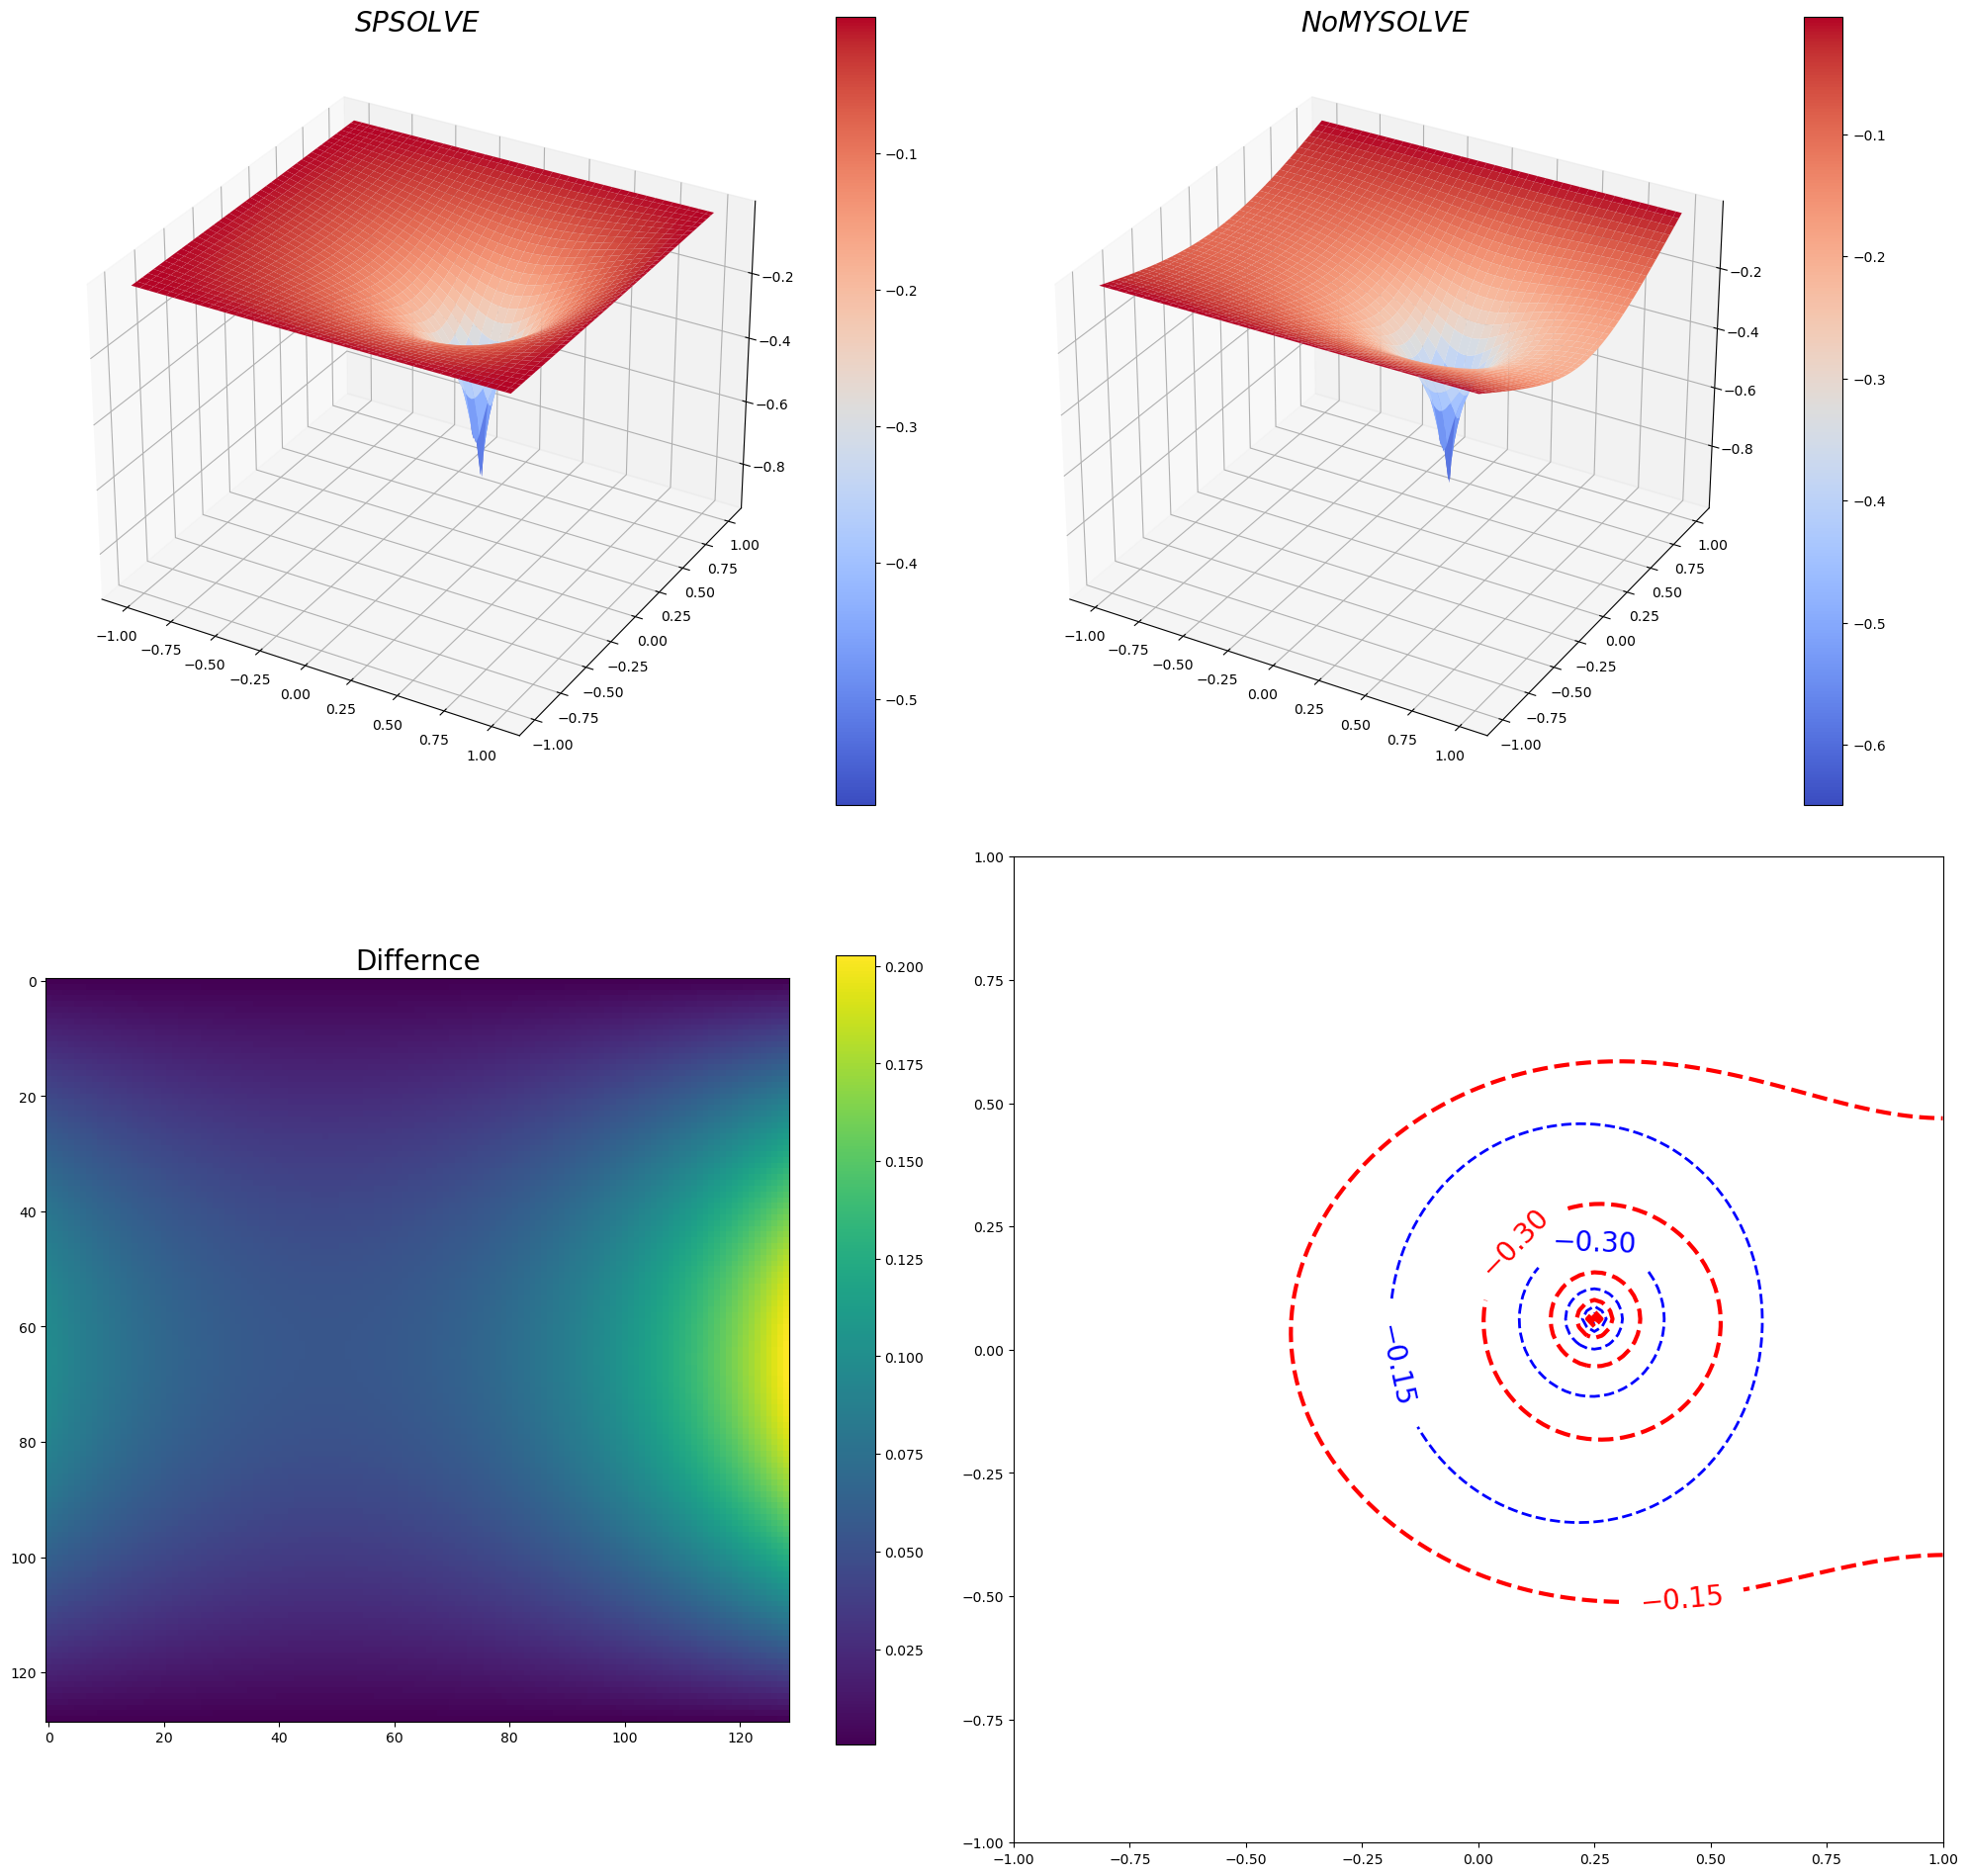

In [28]:
fig = plt.figure()
fig.set_figheight(20)
fig.set_figwidth(20)
# g = normal(f[0], f[1], h=0.08)
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)


ax1.set_title(f'$SPSOLVE$', fontsize=20)
surf_bc = ax1.plot_surface(xx, yy, w, cmap=cm.coolwarm,)
plt.colorbar(surf_bc, shrink=0.8, ax=ax1)

ax2.set_title(f'$No MYSOLVE$', fontsize=20)
surf = ax2.plot_surface(xx, yy, u, cmap=cm.coolwarm,)
plt.colorbar(surf, shrink=0.8, ax=ax2)

ax3.set_title(f'Differnce', fontsize=20)
im = ax3.imshow(np.abs(w - u))
plt.colorbar(im, shrink=0.8, ax=ax3)

ct1 = ax4.contour(xx, yy, w, colors='b', linewidths=2)
ct2 = ax4.contour(xx, yy, u, colors='r', linewidths=3)
ax4.clabel(ct1, inline=True, fontsize=20)
ax4.clabel(ct2, inline=True, fontsize=20)
# h1, _ = ct1.legend_elements()
# h2, _ = ct2.legend_elements()
fig.tight_layout()

In [27]:
data_path = '../data/Locs129/'
AN = sparse.load_npz(f'{data_path}fv_AN.npz').tocsr()
AD = sparse.load_npz(f'{data_path}fv_AD.npz').tocsr()
B = np.load(f'{data_path}fv_B.npy')
b = B[50]
u = spsolve(AN, b).reshape(129, 129)
w = spsolve(AD, b).reshape(129, 129)